In [74]:
import pandas as pd
import numpy as np
import spacy
#from spacy import displacy
from spacy.lang.pt import Portuguese

#imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from lxml import etree
import os
from bs4 import BeautifulSoup
import requests
import xml.etree.ElementTree as ET
import validators
import datetime
import re
import string
import nltk
from nltk.corpus import stopwords

from collections import Counter

In [75]:
#regex
#downloads
nltk.download('stopwords')

stop_words_nltk = nltk.corpus.stopwords.words('portuguese')

def check_dialog(text_):
    pat="(?:</p><p>.*?\(.*?\): —)"
    match=re.findall(pat, text_)
    if match is None :
        return 'no_dialog'
    else:
        for m in match:
            
            return m

def extract_dialog(full_text,characters_for_name):    
    if full_text is None:
        return None
    else:
        dialogs=[(m.start(0), m.end(0)) for m in re.finditer('</p><p></p><p>(.+?): —', full_text)]
        out=[]
        if len(dialogs)==1:
            out.append(full_text[dialogs[0][1]-characters_for_name:])
        if len(dialogs)>1:
            for i in range(0, len(dialogs)-1):
                out.append(full_text[dialogs[i][1]-characters_for_name:dialogs[i+1][0]])
            out.append(full_text[dialogs[len(dialogs)-1][1]-50:])
        return out

    
def extract_party_name(dialogs):
    if dialogs is None:
        return None
    else:
        res=[]
        for i in dialogs:
                    positions=[(m.start(0), m.end(0)) for m in re.finditer('\((.+?)\): —', i)]
                    if len(positions)==0:
                        res.append(['No','No'])
                    else:
                        party=re.findall('\((.+?)\)',i)
                        name_aux=i[positions[0][1]-50:positions[0][1]]
                        name=re.sub(r'\b\w{1,2}\b', '', name_aux).replace('.','').replace ('()','').replace('  ','').replace('<','').replace('>','').replace('/','').replace(': —','')
                        if len(party)>0:
                            party=party[0]
                        res.append([party,name])
        return res

def add_speech_next_page(df):
    for pi in range(1,df.page.max()+1):
        if len(df[df.page==pi].speech.values[0])>0:
            speeches=df[df.page==pi].speech.values[0]
            if '</noscript>' in speeches[-1]:
                
                for n in range(1,df.page.max()-pi):
                    if ': —' in df[df.page==pi+n].text_1.values[0]:
                        
                        in_=df[df.page==pi+n].text_1.values[0].find(': —')
                        df[df.page==pi].speech.values[0][-1]=df[df.page==pi].speech.values[0][-1]+' '+str(df[df.page==pi+n].text_1.values[0][0:in_])
                        
                        break
                    else:
                        
                        df[df.page==pi].speech.values[0][-1]=df[df.page==pi].speech.values[0][-1]+' '+str(df[df.page==pi+n].text_1.values[0])
    return df


#defining the function to remove punctuation
def remove_punctuation(text):
  if(type(text)==float):
    return text
  ans=""  
  for i in text:     
    if i not in string.punctuation:
      ans+=i    
  return ans

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
         
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

def generate_N_grams(text,ngram=1):
  words=[word for word in text]  
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans


def rem(x, names_deputies,parties_ ):
    ans=[]
    dd=names_deputies+parties_
    ddf=np.append(dd,np.array(['sr.as','srs.','presidente','es.a','sr.ª','srº','sr']))
    for i in x.split(' '):
        #print(i)
        if i not in ddf:
            #print(i)
            ans.append(i)

    return ' '.join(ans)

def remove_accents(raw_text):
    """Removes common accent characters.

    Our goal is to brute force login mechanisms, and I work primary with
    companies deploying Engligh-language systems. From my experience, user
    accounts tend to be created without special accented characters. This
    function tries to swap those out for standard Engligh alphabet.
    """

    raw_text = re.sub(u"[àáâãäå]", 'a', raw_text)
    raw_text = re.sub(u"[èéêë]", 'e', raw_text)
    raw_text = re.sub(u"[ìíîï]", 'i', raw_text)
    raw_text = re.sub(u"[òóôõö]", 'o', raw_text)
    raw_text = re.sub(u"[ùúûü]", 'u', raw_text)
    raw_text = re.sub(u"[ç]", 'c', raw_text)

    return raw_text

def add_zeros(int_):
    if len(str(int_))<2:
        return '00'+str(int_)
    if len(str(int_))<3:
        return '0'+str(int_)
    if len(str(int_))==3:
        return str(int_)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caperei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
#political polarization functions

right=[ 'PSD',  'CDS-PP', 'CH','IL','CDS']
left=[ 'PS', 'BE', 'PCP', 'PAN', 'PEV','L','PCP']


def create_frequency_table_grams(n_gram=1, indf=None, right_parties=right, left_parties=left):
    grams_d={1: 'uni_grams', 2: 'bi_grams', 3: 'tri_grams'}
   

    r_grams=[item for sublist in indf[indf.party.isin(right)][grams_d[n_gram]] for item in sublist]
    l_grams=[item for sublist in indf[indf.party.isin(left)][grams_d[n_gram]] for item in sublist]

    total_counter = Counter([item for sublist in indf[grams_d[n_gram]] for item in sublist])
    right_counter = Counter(r_grams)
    left_counter = Counter(l_grams)

    df_all = pd.DataFrame.from_dict(total_counter, orient='index').reset_index()
    df_all.columns=['phrase','count']
    df_all['f_right']=[right_counter[x] for x in df_all.phrase]
    df_all['f_left']=[left_counter[x] for x in df_all.phrase]


    df_all['f_left_total']=sum(left_counter.values())
    df_all['f_right_total']=sum(right_counter.values())
    df_all['f_right_minus']=(df_all['f_right']- df_all['f_right_total'])/df_all['f_right_total']
    df_all['f_left_minus']=(df_all['f_left']- df_all['f_left_total'])/df_all['f_left_total']

    df_all['f_right_norm']=df_all['f_right']/df_all['f_right_total']
    df_all['f_left_norm']=df_all['f_left']/df_all['f_left_total']

    df_all['f_right_minus_norm']=df_all['f_right_minus']/df_all['f_right_total']
    df_all['f_left_minus_norm']=df_all['f_left_minus']/df_all['f_left_total']

    return df_all


def calculate_pearson(df_all):
    aa=df_all['f_right_norm']*df_all['f_left_minus_norm'] 
    bb=df_all['f_left_norm']*df_all['f_right_minus_norm']
    cc=aa-bb
    dd=cc*cc
    d11=df_all['f_right_norm']+df_all['f_left_norm']
    d22=df_all['f_right_norm']+df_all['f_right_minus_norm']
    d33=df_all['f_left_norm']+df_all['f_left_minus_norm']
    d44=df_all['f_right_minus_norm']+df_all['f_left_minus_norm']
    denom=d11*d22*d33*d44
    pp=dd/denom
    return pp

def create_phrase_partisanship(df):
    aa=df['f_right_norm']+df['f_left_norm']
    df['rho']=df['f_right_norm']/aa
    bb=1-df['f_right_norm']
    df['f_left_norm_scaled']=df['f_right_norm']/bb
    cc=1-df['f_left_norm']
    df['f_right_norm_scaled']=df['f_left_norm']/cc
    df['pi']=df['f_right_norm']*df['rho']
    df['pi_scaled']=(df['pi']/(1-df['f_right_norm']))+((1-df['pi'])/(1-df['f_left_norm']))

    df['gram_partisanship']= 0.5 * (1 - df['pi_scaled'] + 
                           (df['f_right_norm_scaled'] +  df['f_left_norm_scaled']) * df['rho'])
    return df

def create_polarization_correlation(df):
    
    aa=df['f_left_norm']*-1
    bb= df['f_right_norm']*1
    df['beta_polarization']=aa+bb

    return df

In [77]:
declaracoes2 = pd.read_csv("speech_selected.csv")
declaracoes2["no_punct"] = declaracoes2["speech"].str.replace('[^\w\s]','')
declaracoes2["no_punct"] = declaracoes2["no_punct"].str.lower()
declaracoes2=declaracoes2[~declaracoes2.no_punct.isna()]


In [78]:
deputies=pd.read_csv('deputies_2015_now.csv')
names_deputies= deputies['nome'].str.lower().values
parties_= deputies['partido'].str.lower().values

In [79]:

declaracoes2.loc[declaracoes2["party"] == "PEN", "party"] = 'PAN'

declaracoes2.loc[declaracoes2["party"] == "OS Verdes", "party"] = 'PEV'
declaracoes2.loc[declaracoes2["party"] == "Os verdes", "party"] = 'PEV'
declaracoes2.loc[declaracoes2["party"] == "Os Vedes", "party"] = 'PEV'
declaracoes2.loc[declaracoes2["party"] == "Os Verdes", "party"] = 'PEV'
declaracoes2.loc[declaracoes2["party"] == "s Verdes", "party"] = 'PEV'

declaracoes2.loc[declaracoes2["party"] == "SD", "party"] = 'PSD'
declaracoes2.loc[declaracoes2["party"] == "PD", "party"] = 'PSD'

declaracoes2.loc[declaracoes2["party"] == "CDS", "party"] = 'CDS-PP'
declaracoes2.loc[declaracoes2["party"] == "CSD-PP", "party"] = 'CDS-PP'
declaracoes2.loc[declaracoes2["party"] == "CDS-P", "party"] = 'CDS-PP'

declaracoes2.loc[declaracoes2["party"] == "PC", "party"] = 'PCP'
declaracoes2.loc[declaracoes2["party"] == "CDU", "party"] = 'PCP'

declaracoes2.loc[declaracoes2["party"] == "B E", "party"] = 'BE'
declaracoes2.loc[declaracoes2["party"] == "Bloco de Esquerda", "party"] = 'BE'

declaracoes2.loc[declaracoes2["party"] == "Partido Socialista", "party"] = 'PS' 

partiesss=['PS', 'PSD', 'BE', 'PCP', 'CDS-PP', 'PAN', 'PEV','CH','IL','L']
declaracoes2=declaracoes2[declaracoes2.party.isin(partiesss)]

In [80]:

declaracoes2['no_punct']= declaracoes2['no_punct'].apply(lambda x:remove_accents(x))
declaracoes2['speech1']=declaracoes2['no_punct'].apply(lambda x:rem(x, names_deputies,parties_ ) )
declaracoes2['tokenized_text'] = declaracoes2['speech1'].apply(lambda x: nltk.word_tokenize(x))
declaracoes2['normalized_tokens'] = declaracoes2['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = None))
declaracoes2['normalized_tokens_count'] = declaracoes2['normalized_tokens'].apply(lambda x: len(x))
#declaracoes2['uni_grams'] = declaracoes2['normalized_tokens'].apply(lambda x: generate_N_grams(x,1))
#declaracoes2['bi_grams'] = declaracoes2['normalized_tokens'].apply(lambda x: generate_N_grams(x,2))
declaracoes2['tri_grams'] = declaracoes2['normalized_tokens'].apply(lambda x: generate_N_grams(x,3))

In [81]:
dates_df=pd.read_csv('datas_leg.csv')
dates_df['number']=[int(x[-3:]) for x in dates_df['Número']]
dates_df['number']=[int(x[-3:]) for x in dates_df['Número']]
dates_df.columns=['Número', 'date', 'Publicação', 'N.º de Páginas', 'legislatura',
       'session', 'number']
       

In [82]:
declaracoes2=pd.merge(declaracoes2, dates_df[['legislatura',	'session'	,'number','date']],  how='left', left_on=['legislatura',	'session'	,'number'], right_on = ['legislatura',	'session'	,'number'])

In [83]:
declaracoes2.head()

,Unnamed: 0,speaker,party,speech,filename,number,session,legislatura,no_punct,speech1,tokenized_text,normalized_tokens,normalized_tokens_count,tri_grams,date
0,1,teresa leal coelho,PSD,Muito bem!,darl13sl01n001.txt,1,1,13,muito bem,muito bem,"[muito, bem]",[bem],1,[],23/10/2015
1,2,nuno magalhães,CDS-PP,"Peço a palavra, Sr. Presidente.",darl13sl01n001.txt,1,1,13,peco a palavra sr presidente,peco a palavra,"[peco, a, palavra]","[peco, palavra]",2,[],23/10/2015
2,3,nuno magalhães,CDS-PP,"Sr. Presidente, queria apenas esclarecer que n...",darl13sl01n001.txt,1,1,13,sr presidente queria apenas esclarecer que nao...,queria apenas esclarecer que nao se trata de u...,"[queria, apenas, esclarecer, que, nao, se, tra...","[queria, apenas, esclarecer, nao, trata, caso,...",30,"[queria apenas esclarecer, apenas esclarecer n...",23/10/2015
3,4,nuno magalhães,CDS-PP,"Sr. Presidente, Sr.as e Srs. Deputados: Não po...",darl13sl01n001.txt,1,1,13,sr presidente sras e srs deputados nao posso n...,sras e srs deputados nao posso nem quero deixa...,"[sras, e, srs, deputados, nao, posso, nem, que...","[sras, srs, deputados, nao, posso, quero, deix...",26,"[sras srs deputados, srs deputados nao, deputa...",23/10/2015
4,5,nuno magalhães,CDS-PP,O Sr. Presidente falou do ex-Presidente Jaime ...,darl13sl01n001.txt,1,1,13,o sr presidente falou do expresidente jaime ga...,o falou do expresidente jaime gama pois bem de...,"[o, falou, do, expresidente, jaime, gama, pois...","[falou, expresidente, jaime, gama, pois, bem, ...",102,"[falou expresidente jaime, expresidente jaime ...",23/10/2015


In [84]:
declaracoes2.speaker.unique()

array(['teresa leal coelho', 'nuno magalhães', 'joão oliveira',
       'josé manuel pureza', 'antónio costa', 'telmo correia',
       'heloísa apolónia', 'luís montenegro', 'pedro filipe soares',
       'jorge falcato simões', 'helena roseta', 'pedro nuno santos',
       'antónio filipe', 'adão silva', 'isabel galriça neto',
       'jorge machado', 'fernando rocha andrade', 'paula santos',
       'rita rato', 'joão galamba', 'carlos césar', 'ana paula vitorino',
       'paula teixeira da cruz', 'andré silva', 'jerónimo de sousa',
       'hugo lopes soares', 'cecília meireles', 'pedro delgado alves',
       'miguel santos', 'carlos abreu amorim', 'bruno dias',
       'paulo trigo pereira', 'joana mortágua', 'josé moura soeiro',
       'josé luís ferreira', 'teresa caeiro', 'catarina martins',
       'isabel pires', 'mário centeno', 'duarte pacheco',
       'eduardo cabrita', 'berta cabral', 'luís leite ramos',
       'antónio leitão amaro', 'mariana mortágua', 'paulo sá',
       'franci

In [85]:
declaracoes2[declaracoes2.speaker=='idália salvador serrão']

,Unnamed: 0,speaker,party,speech,filename,number,session,legislatura,no_punct,speech1,tokenized_text,normalized_tokens,normalized_tokens_count,tri_grams,date
25178,38153,idália salvador serrão,PS,"Sr. Presidente, Sr.ª Deputada Teresa Morais, o...",darl13sl02n038.txt,38,2,13,sr presidente srª deputada teresa morais ouvi ...,srª deputada teresa morais ouvi atentamente a ...,"[srª, deputada, teresa, morais, ouvi, atentame...","[srª, deputada, teresa, morais, ouvi, atentame...",273,"[srª deputada teresa, deputada teresa morais, ...",13/01/2017
25179,38154,idália salvador serrão,PS,Os Deputados do Partido Socialista e das outra...,darl13sl02n038.txt,38,2,13,os deputados do partido socialista e das outra...,os deputados do partido socialista e das outra...,"[os, deputados, do, partido, socialista, e, da...","[deputados, partido, socialista, outras, forca...",31,"[deputados partido socialista, partido sociali...",13/01/2017
25180,38155,idália salvador serrão,PS,"Os trabalhos estão em curso, já houve duas reu...",darl13sl02n038.txt,38,2,13,os trabalhos estao em curso ja houve duas reun...,os trabalhos estao em curso ja houve duas reun...,"[os, trabalhos, estao, em, curso, ja, houve, d...","[trabalhos, estao, curso, ja, duas, reunioes, ...",167,"[trabalhos estao curso, estao curso ja, curso ...",13/01/2017
25181,38156,idália salvador serrão,PS,Exato!,darl13sl02n038.txt,38,2,13,exato,exato,[exato],[exato],1,[],13/01/2017
25182,38157,idália salvador serrão,PS,"Está mal informada, tem de se informar melhor,...",darl13sl02n038.txt,38,2,13,esta mal informada tem de se informar melhor s...,esta mal informada tem de se informar melhor s...,"[esta, mal, informada, tem, de, se, informar, ...","[mal, informada, informar, melhor, srª, deputada]",6,"[mal informada informar, informada informar me...",13/01/2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59878,91526,idália salvador serrão,PS,Pois não!,darl13sl03n099.txt,99,3,13,pois nao,pois nao,"[pois, nao]","[pois, nao]",2,[],27/06/2018
59879,91527,idália salvador serrão,PS,"Agora estão distraídos, a assobiar para o lado!",darl13sl03n099.txt,99,3,13,agora estao distraidos a assobiar para o lado,agora estao distraidos a assobiar para o lado,"[agora, estao, distraidos, a, assobiar, para, ...","[agora, estao, distraidos, assobiar, lado]",5,"[agora estao distraidos, estao distraidos asso...",27/06/2018
59880,91528,idália salvador serrão,PS,Não foi por capricho ideológico!,darl13sl03n099.txt,99,3,13,nao foi por capricho ideologico,nao foi por capricho ideologico,"[nao, foi, por, capricho, ideologico]","[nao, capricho, ideologico]",3,[nao capricho ideologico],27/06/2018
59881,91529,idália salvador serrão,PS,E…?!,darl13sl03n099.txt,99,3,13,e,e,[e],[],0,[],27/06/2018


In [86]:
presidents_secret=['idália salvador serrão','ana mesquita','nelson peralta','abel baptista','diogo leão','fernando negrão','helga correia','lina lopes','eduardo ferro rodrigues','maria da luz rosinha','duarte pacheco','rosa maria bastos albernaz','alberto martins','sandra pontedeira','jorge lacão','pedro alves', 'sandra pontedeira','emília santos','antónio carlos monteiro']
declaracoes2=declaracoes2[~declaracoes2.speaker.isin(presidents_secret)] 

In [88]:
dfg3=create_frequency_table_grams(n_gram=3, indf=declaracoes2, right_parties=right, left_parties=left)
dfg3['pearson_quad']=calculate_pearson(dfg3)
trigrams_table=dfg3[dfg3.pearson_quad>0]
trigrams_table=create_phrase_partisanship(trigrams_table)
trigrams_table=create_polarization_correlation(trigrams_table)
final_df = trigrams_table.sort_values(by=['gram_partisanship'], ascending=False)

indexes_no_applause=[n for n,x in enumerate(final_df.phrase) if 'aplausos' not in x]
final_df=final_df.iloc[indexes_no_applause]

tri_final = final_df[0:200].append(final_df[-200:], ignore_index=True)


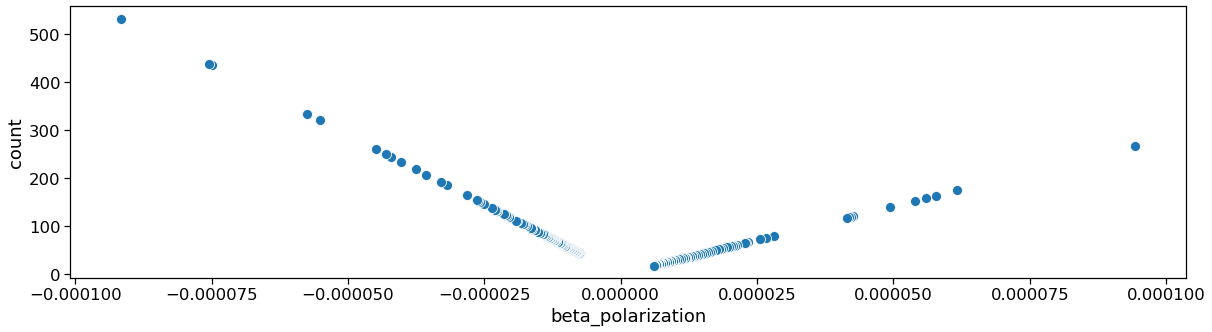

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="beta_polarization",y='count',s=100,
                data=tri_final)

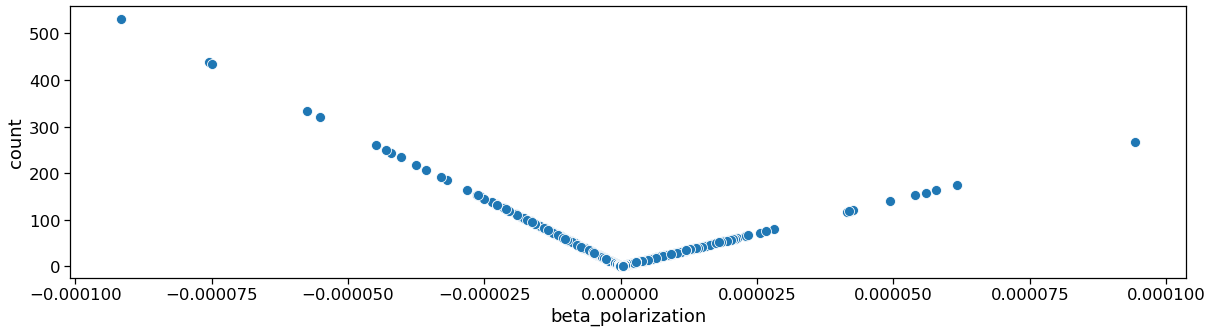

In [ ]:
plt.figure(figsize=(20,5))
with sns.plotting_context("notebook",font_scale=1.5):
    sns.scatterplot(x="beta_polarization",y='count',s=100,
                data=trigrams_table)

In [89]:
#create link
tri_final['reference'] = [[]] * tri_final.shape[0]
for n,x in enumerate(tri_final.phrase):
    a=[i.count(x) for i in declaracoes2.tri_grams]
    indexes=np.where(np.array(a) >= 3)[0]
    list_links=[]
    for i in indexes:
        number=add_zeros(declaracoes2.iloc[i].number ) 
        legislature=declaracoes2.iloc[i].legislatura 
        session=declaracoes2.iloc[i].session 
        date=datetime.datetime.strptime(declaracoes2.iloc[i].date , '%d/%m/%Y').strftime('%Y-%m-%d')
        url_=f'https://debates.parlamento.pt/catalogo/r3/dar/01/{legislature}/{session}/{number}/{date}' 
        list_links.append(url_)
    if list_links==[]:
        list_links=['does not appear more than 3 times']

    tri_final.iloc[n, tri_final.columns.get_loc('reference')].append(list(set(list_links)))
 


In [90]:
tri_final.to_csv('trigrams_polarized.csv')

In [92]:
final_df.shape[0]/2+200

2139634.0

In [95]:
discutidos_final = final_df[int(final_df.shape[0]/2-200):int(final_df.shape[0]/2)].append(final_df[int(final_df.shape[0]/2):int(final_df.shape[0]/2+200)], ignore_index=True)

In [96]:
discutidos_final

,phrase,count,f_right,f_left,f_left_total,f_right_total,f_right_minus,f_left_minus,f_right_norm,f_left_norm,f_right_minus_norm,f_left_minus_norm,pearson_quad,rho,f_left_norm_scaled,f_right_norm_scaled,pi,pi_scaled,gram_partisanship,beta_polarization
0,considerados superiores propria,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
1,consumo familias secretario,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
2,superiores propria tributacao,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
3,propria tributacao impedem,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
4,tributacao impedem visto,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,mendes saudo palavras,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
396,saudo palavras quero,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
397,armadas presentes galerias,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07
398,representativas militares forcas,1,0,1,5806912,2818821,-1.0,-1.0,0.0,1.722086e-07,-3.547582e-07,-1.722085e-07,3.909260e+06,0.0,0.0,1.722086e-07,0.0,1.0,-8.610430e-08,-1.722086e-07


In [97]:
#create link
discutidos_final['reference'] = [[]] * discutidos_final.shape[0]
for n,x in enumerate(discutidos_final.phrase):
    a=[i.count(x) for i in declaracoes2.tri_grams]
    indexes=np.where(np.array(a) >= 3)[0]
    list_links=[]
    for i in indexes:
        number=add_zeros(declaracoes2.iloc[i].number ) 
        legislature=declaracoes2.iloc[i].legislatura 
        session=declaracoes2.iloc[i].session 
        date=datetime.datetime.strptime(declaracoes2.iloc[i].date , '%d/%m/%Y').strftime('%Y-%m-%d')
        url_=f'https://debates.parlamento.pt/catalogo/r3/dar/01/{legislature}/{session}/{number}/{date}' 
        list_links.append(url_)
    if list_links==[]:
        list_links=['does not appear more than 3 times']

    discutidos_final.iloc[n, discutidos_final.columns.get_loc('reference')].append(list(set(list_links)))

In [98]:
discutidos_final.to_csv('temas_discutidos.csv')